## First steps with tensorflow

[The complete learning notebook](https://colab.research.google.com/notebooks/mlcc/first_steps_with_tensor_flow.ipynb)

### Learning Objectives
- Learn Tensorflow concepts
- Use **LinearRegressor** class to predict median housing price, at the granularity of city blocks, based on one input feature
- Evaluate the accuracy of a model's predictions using Root Mean Square Error(RMSE)
- Improve accuracy of a model by tuning its hyperparameters

The [data](https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv) is based on 1990 census data from California.

### Setup
The necessary libraries are loaded


In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")


- We'll randomize the data, just to be sure not to get any pathological ordering effects that might harm the performance of Stochastic Gradient Descent.
- We'll scale down median_house_value to be in units of thousands so it can be learned a little more easily with learning rates in a range that we usually use

In [2]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
13393,-121.9,37.8,11.0,2836.0,373.0,959.0,335.0,10.6,500.0
16477,-122.6,38.2,20.0,1888.0,411.0,826.0,396.0,2.9,189.1
4826,-118.1,33.9,31.0,1983.0,419.0,1157.0,390.0,3.5,168.3
6480,-118.3,34.0,24.0,323.0,214.0,751.0,189.0,1.8,225.0
4640,-118.1,34.1,41.0,2869.0,563.0,1627.0,533.0,5.1,270.7
...,...,...,...,...,...,...,...,...,...
9084,-119.0,35.3,36.0,1590.0,367.0,1311.0,390.0,1.7,52.9
16672,-122.8,38.4,14.0,4143.0,656.0,1569.0,629.0,4.0,345.3
4627,-118.1,34.6,34.0,3416.0,601.0,1929.0,567.0,4.0,107.4
13975,-122.0,37.9,33.0,2423.0,322.0,998.0,346.0,7.5,349.1


### Examine the data
It's always a good idea to examine the dataset before we start working on it. 

In [3]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


### Build the model
#### Step 1: Define Features and Configure Feature Columns
In Tensorflow, we indicate a feature's data type using a construct called a **feature column**. Feature column stores only a description of the feature data; they do not contain the feature data itself.

In [4]:
# Define the input feature: total_rooms
my_feature = california_housing_dataframe[['total_rooms']]

# Configure a numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column('total_rooms')]

#### Step 2: Define the target
We'll define our target, which is median_house_value. Again, we can pull it from out dataframe

In [5]:
# Define the label
targets = california_housing_dataframe['median_house_value']

#### Step 3: Configure the LinearRegressor
**GradientDescentOptimizer** is used for training the model. It implements **Mini-Batch Stochastic Gradient Descent**. The learning_rate arguement controls the size of the gradient step.

To avoid making the magnitude of the gradient too large, we use gradient clipping which is applied to our optimizer through **clip_gradients_by_norm**

In [6]:
# Use gradient descent as the optimizer for training the model.
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns = feature_columns,
    optimizer = my_optimizer
)

#### Step 4: Define the input function
To import our data into our LinearRegressor, we need to define an input function which instructs Tensorflow how to preprocess the data, as well as how to batch, shuffle, and repeat it during model training


In [8]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
     # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

#### Step 5: Train the model
We can call train() on our linear_regressor to train the model. We'll wrap `input_fn` in a lambda so we can pass in my_Feature and target as arguements

In [9]:
_ = linear_regressor.train(
    input_fn = lambda:input_fn(my_feature, targets),
    steps = 100
)

#### Step 6: Evaluate the model
Let's predict how well our model fit training_data during training

In [10]:
# Create an input function for predictions
prediction_input_fn = lambda: input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on linear regressor to make predictions
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a numpy array, so we can calculate error metrics
predictions = np.array([item['predictions'][0] for item in predictions])

# PRint MSE and RMSE
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)

print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 56367.025
Root Mean Squared Error (on training data): 237.417


MSE can be hard to interpret, so we often look at RMSE instead. RMSE can be interpreted on the same scale as the original targets.

In [11]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


Our error spans nearly half the range of the target values. Can we do better?

This is the question that nags at every model developer. Let's develop some basic strategies to reduce model error.

The first thing we can do is take a look at how well our predictions match our targets, in terms of overall summary statistics.


In [12]:
calibration_data = pd.DataFrame()
calibration_data['predictions'] = pd.Series(predictions)
calibration_data['targets'] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


Okay, maybe this information is helpful. How does the mean value compare to the model's RMSE? How about the various quantiles?

We can also visualize the data and the line we've learned. Recall that linear regression on a single feature can be drawn as a line mapping input x to output y.

First, we'll get a uniform random sample of the data so we can make a readable scatter plot.


In [13]:
sample = california_housing_dataframe.sample(n=300)

Next, we'll plot the line we've learned, drawing from the model's bias term and feature weight, together with the scatter plot. The line will show up red.

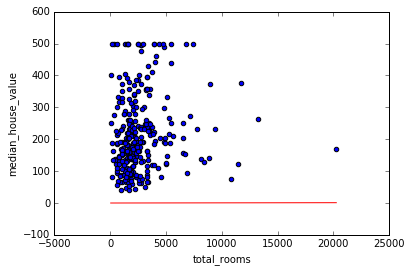

In [14]:
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()